# Finding the suspect

- **Boilerplate Code:** Coursera course - Bayesian Methods for Machine Learning, HSE University
- **Solution:** Josef Brechler

<a href="https://en.wikipedia.org/wiki/Facial_composite">Facial composites</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques is evolutionary systems that compose the final face from many predefined parts.

In this project, we will try to implement an app for creating a facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

The final project is developed in a way that you can apply learned techniques to real project yourself. We will include the main guidelines and hints, but a great part of the project will need your creativity and experience from previous assignments.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
!pip install GPy
!pip install GPyOpt
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=ae7661d5ecc6fe8ea163776113798ec378b18a781b4d95f72c34e62e66b0d123
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=7d5456529e3f637bc2289a37ffc33c9b6013ea0bec501f94e48721b3b858d4f7
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose  #  Deconv2D (https://stackoverflow.com/questions/55190692/transposed-convolution-in-tf-keras-layers)
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import os
import time
import utils  # upload utils.py to runtime
%matplotlib inline

import tensorflow_probability as tfp

In [3]:
def download_file(url, file_path):
    print(url, file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
    template = "wget '{}' -O '{}'"
    os.system(template.format(url, file_path))

In [4]:
# download pretrained model
download_file(
    "https://github.com/hse-aml/bayesian-methods-for-ml/"
    "releases/download/v0.1/CelebA_VAE_small_8.h5",
    "CelebA_VAE_small_8.h5"
)

https://github.com/hse-aml/bayesian-methods-for-ml/releases/download/v0.1/CelebA_VAE_small_8.h5 CelebA_VAE_small_8.h5


## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is dense. That means that we can traverse the latent space and reconstruct any point along our path into a valid face.

Using this continuous latent space we can use Bayesian optimization to maximize some similarity function between a person's face in victim/witness's memory and a face reconstructed from the current point of latent space. Bayesian optimization is an appropriate choice here since people start to forget details about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Author's approach description:


1.   At the beginning the user is provided  `n_start` images. In order to explore the feature space efficiently the initial points are generated by the `get_dispersed_points` procedure, whitch iteratively look for set of `n_start` points with the highest total Minkowski distance to each other. The Minkowski distance was chosen because it is parametrized. Choosing the right value of the parameter `p` (we use 0.7) results to even distribution of the samples over the latent space. Therefore the initially generated faces are not similar to each other.
2.   User is asked to rank the images from the best to the worst. Integer scores are assigned evenly to the ranked images. Please note that the score step is 3, so for example 5 images will have scores (13, 10, 7, 4, 1) from the best to the worst.
3.   Optimization is performed using `GPyOpt.methods.BayesianOptimization`. Please refer to the procedure for specific setup. I tried to play with parameters somewhat to achieve optimal results.
4.   After the initial set of images user is asked to rate `n_iter` new images, generated by the bayesian optimization procedure. The candidate points search is run after each newly provided image is rated.

Limitation - I am not really satisfied with the way the quality of the newly generated images. Yet it has to do also with the quality of the VAE.



## Obtain encoder and decoder objects

For this task, you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Aligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of the final project if you wish to train VAE on your own.

<b>Task 1:</b> Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignments. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

In [5]:
from tensorflow.python.keras import backend as K

In [6]:
sess = tf.compat.v1.Session()
K.set_session(sess)

In [7]:
# size latent variable space
latent_size = 8

In [8]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)

In [9]:
vae.load_weights('CelebA_VAE_small_8.h5')

In [10]:
K.set_learning_phase(False)
K.learning_phase()

False

## Generate single image

In [29]:
random_sample_latent = tf.random.normal(shape=(1, latent_size))
random_sample_image = tf.convert_to_tensor(decoder(random_sample_latent)[0], dtype=tf.float32)

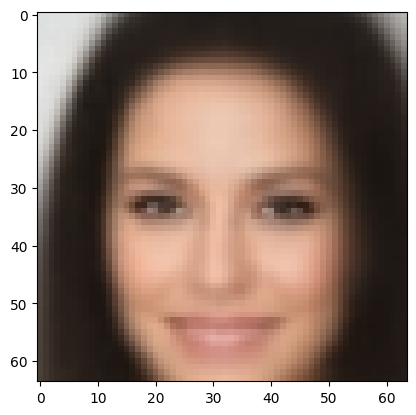

In [30]:
plt.imshow(np.clip(random_sample_image, 0, 1))

 **JB:** .fit method is not called here, pretrained weights are loaded through .load_weights instead.

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As the first part of the assignment, you need to become familiar with the trained model. For all tasks, you will only need a decoder to reconstruct samples from a latent space.

To decode the latent variable, you need to run ```decode``` operation defined above with random samples from a standard normal distribution.

In [12]:
# draw 25 samples from VAE here
n_samples = 25
latent = 8

# sample from standard normal distribution
standard_normal = tfp.distributions.Normal(loc=[0] * latent, scale=[1] * latent)
sample_im_t = standard_normal.sample([n_samples])

In [13]:
# decode form latent space -> image
sampled_im_decoded = decoder(sample_im_t)
type(sampled_im_decoded)

tensorflow.python.framework.ops.EagerTensor

In [14]:
# convert to tensor (numpy)
sampled_im_tensor = tf.convert_to_tensor(sampled_im_decoded, dtype=tf.float32)
print(type(sampled_im_tensor))
print(type(sampled_im_tensor[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


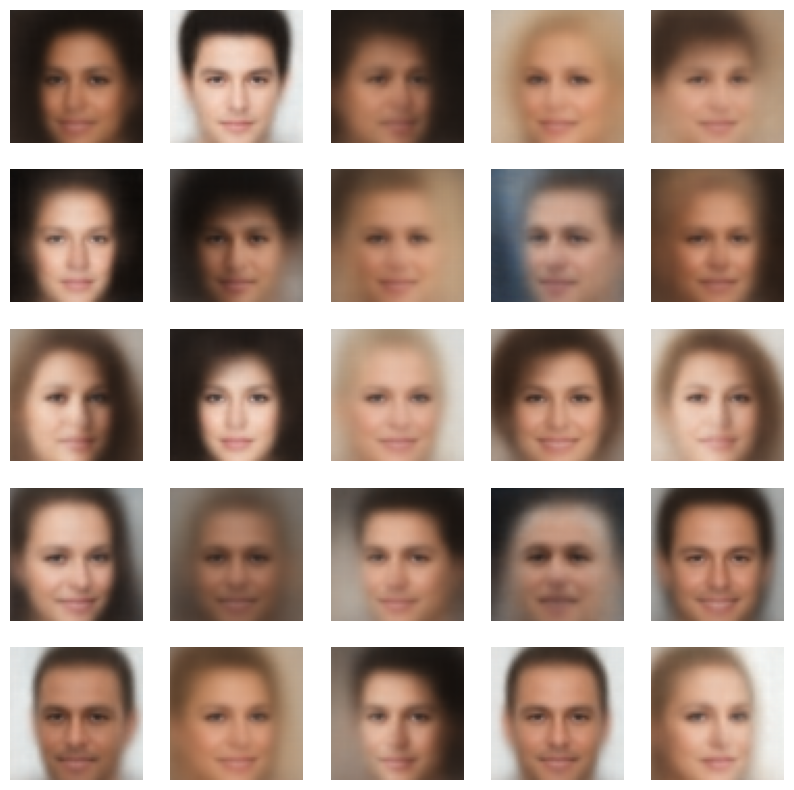

In [15]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    image = sampled_im_tensor[i]
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according to their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image, you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). A user then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying `acquisition_type` and `acquisition_par` parameters.

In [16]:
def get_dispersed_points(n_iter = 10, dist_coef = 0.5, n_samples=5, latent_size=8):
    '''
    Generate n_samples points with the highest mutual Minkowski distance.
    :param n_iter: number of trials to choose set of points from.
    :param dist_coef: Minkowski distance coefficient.
    :param n_samples: number of images to rank initialy.
    :param latent_size: ndim of latent space
    '''

    # # debug purposes
    # n_samples = 5
    # latent_size = 8
    # n_iter = 3
    # dist_coef = 1/2  # prefers distributing points evenly

    winner_total_dist = 0
    dist = lambda p1, p2: sum(abs(p1 - p2)**dist_coef)**dist_coef
    winner_set = None

    for idx in range(n_iter):
        set_now = np.random.normal(size=(n_samples,latent_size))
        dist_mat_now = np.asarray([[dist(p1, p2) for p2 in set_now] for p1 in set_now])
        total_dist_now = sum(sum(dist_mat_now)/2)

        # print(dist_mat_now)
        # print(total_dist_now)

        if winner_total_dist < total_dist_now:
            winner_total_dist = total_dist_now
            winner_set = set_now

    return winner_set

In [17]:
# test how the output works
get_dispersed_points(n_iter = 100, dist_coef = 0.7, n_samples=2)

array([[ 0.06834397,  1.47843882, -1.32881091,  0.52008685, -0.06631008,
        -3.39789618, -0.61976446,  1.44060944],
       [ 0.10299435, -1.07859401,  0.40979338, -1.65589531,  1.849933  ,
         0.47345586, -2.79038956, -0.78284434]])

In [18]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.decoder = decoder
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        latent_tensor = tf.convert_to_tensor(latent[None, :], dtype=tf.float32)
        img = self.decoder(latent_tensor)[0].numpy()
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        n = len(titles)
        plt.figure(figsize=(3*n, 3*((n//2)+1)))
        # n = len(titles)
        for i in range(n):
            # plt.subplot(1, n, i+1)
            plt.subplot(2, (n//2)+1, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start=5, select_top=5, latent_size=8):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep.
        :param latent_size: ndim of latent space.
        '''

        self.samples = get_dispersed_points(n_iter = 100, dist_coef = 0.7, n_samples=n_start, latent_size=latent_size)
        print(self.samples)
        self.images = np.array([facial_composit._get_image(t) for t in self.samples])
        self.rating = [None] * n_start

        titles = ['Image number: ' + str(x) for x in range(1,len(self.images)+1)]
        self._show_images(self.images, titles)

        # workaround for making input() call working
        time.sleep(1)

        print('Rank the images from the best to the worst, separate by commma (,).')
        print('E.g. use 3,1,2 for ranking the third image as the best and the second image as the worst in case of three images in total.')
        ranking_text = input()

        # convert ranking to rating
        ranking_int=list(map(int, ranking_text.split(',')))
        step = 3
        ranking = np.array([ranking_int, list(reversed(range(1,
                                                             (len(ranking_int))*step,
                                                             3)))])

        self.rating = np.array(ranking[:, ranking[0].argsort()][1])

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def optimize(self, n_iter=3, w=4, acquisition_type='EI', acquisition_jitter=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)}
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        # acquisition_jitter = acquisition_jitter,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=-self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)

        ### YOUR CODE HERE
        ## Show user an image and ask to assign score to it.
        ## You may want to show some images to user along with their scores
        ## You should also save candidate, corresponding image and rating

        # # show existing images
        # titles = ['Current rating: ' + str(x) for x in self.rating]
        # self._show_images(self.images, titles)

        time.sleep(1)

        candidate_img = np.array([facial_composit._get_image(candidate[0])])

        # show existing images
        titles = ['Current rating: ' + str(x) for x in self.rating] + ['Candidate']
        images = np.append(self.images, candidate_img, axis=0)
        self._show_images(images, titles)

        # # workaround for making input() call working
        time.sleep(1)

        print('Rate the image with rating. Please see currently assigned ratings above the images!')
        candidate_rating = int(input())

        self.images = np.append(self.images, candidate_img, axis=0)
        self.rating = np.append(self.rating, [candidate_rating], axis=0)
        self.samples = np.append(self.samples, candidate, axis=0)

        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating
        # return 6

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

In [19]:
# facial_composit = FacialComposit(decoder=decoder, latent_size=8)
# facial_composit.optimize()

In [20]:
facial_composit = FacialComposit(decoder=decoder, latent_size=8)

**JB:** _get_image method expects numpy array to be supplied. The following example transforms earlier generated t values from Tensor to Numpy array.

In [21]:
sample_image_input_test = sample_im_t.numpy()[0]
facial_composit._get_image(sample_image_input_test).shape

(64, 64, 3)

## Testing your algorithm

In these sections, we will apply the implemented app to search for different people. Each task will ask you to generate images that will have some property like "dark hair" or "mustache". You will need to run your search algorithm and provide the best discovered image.

#### Task 3.1: Finding person with darkest hair (3 points)

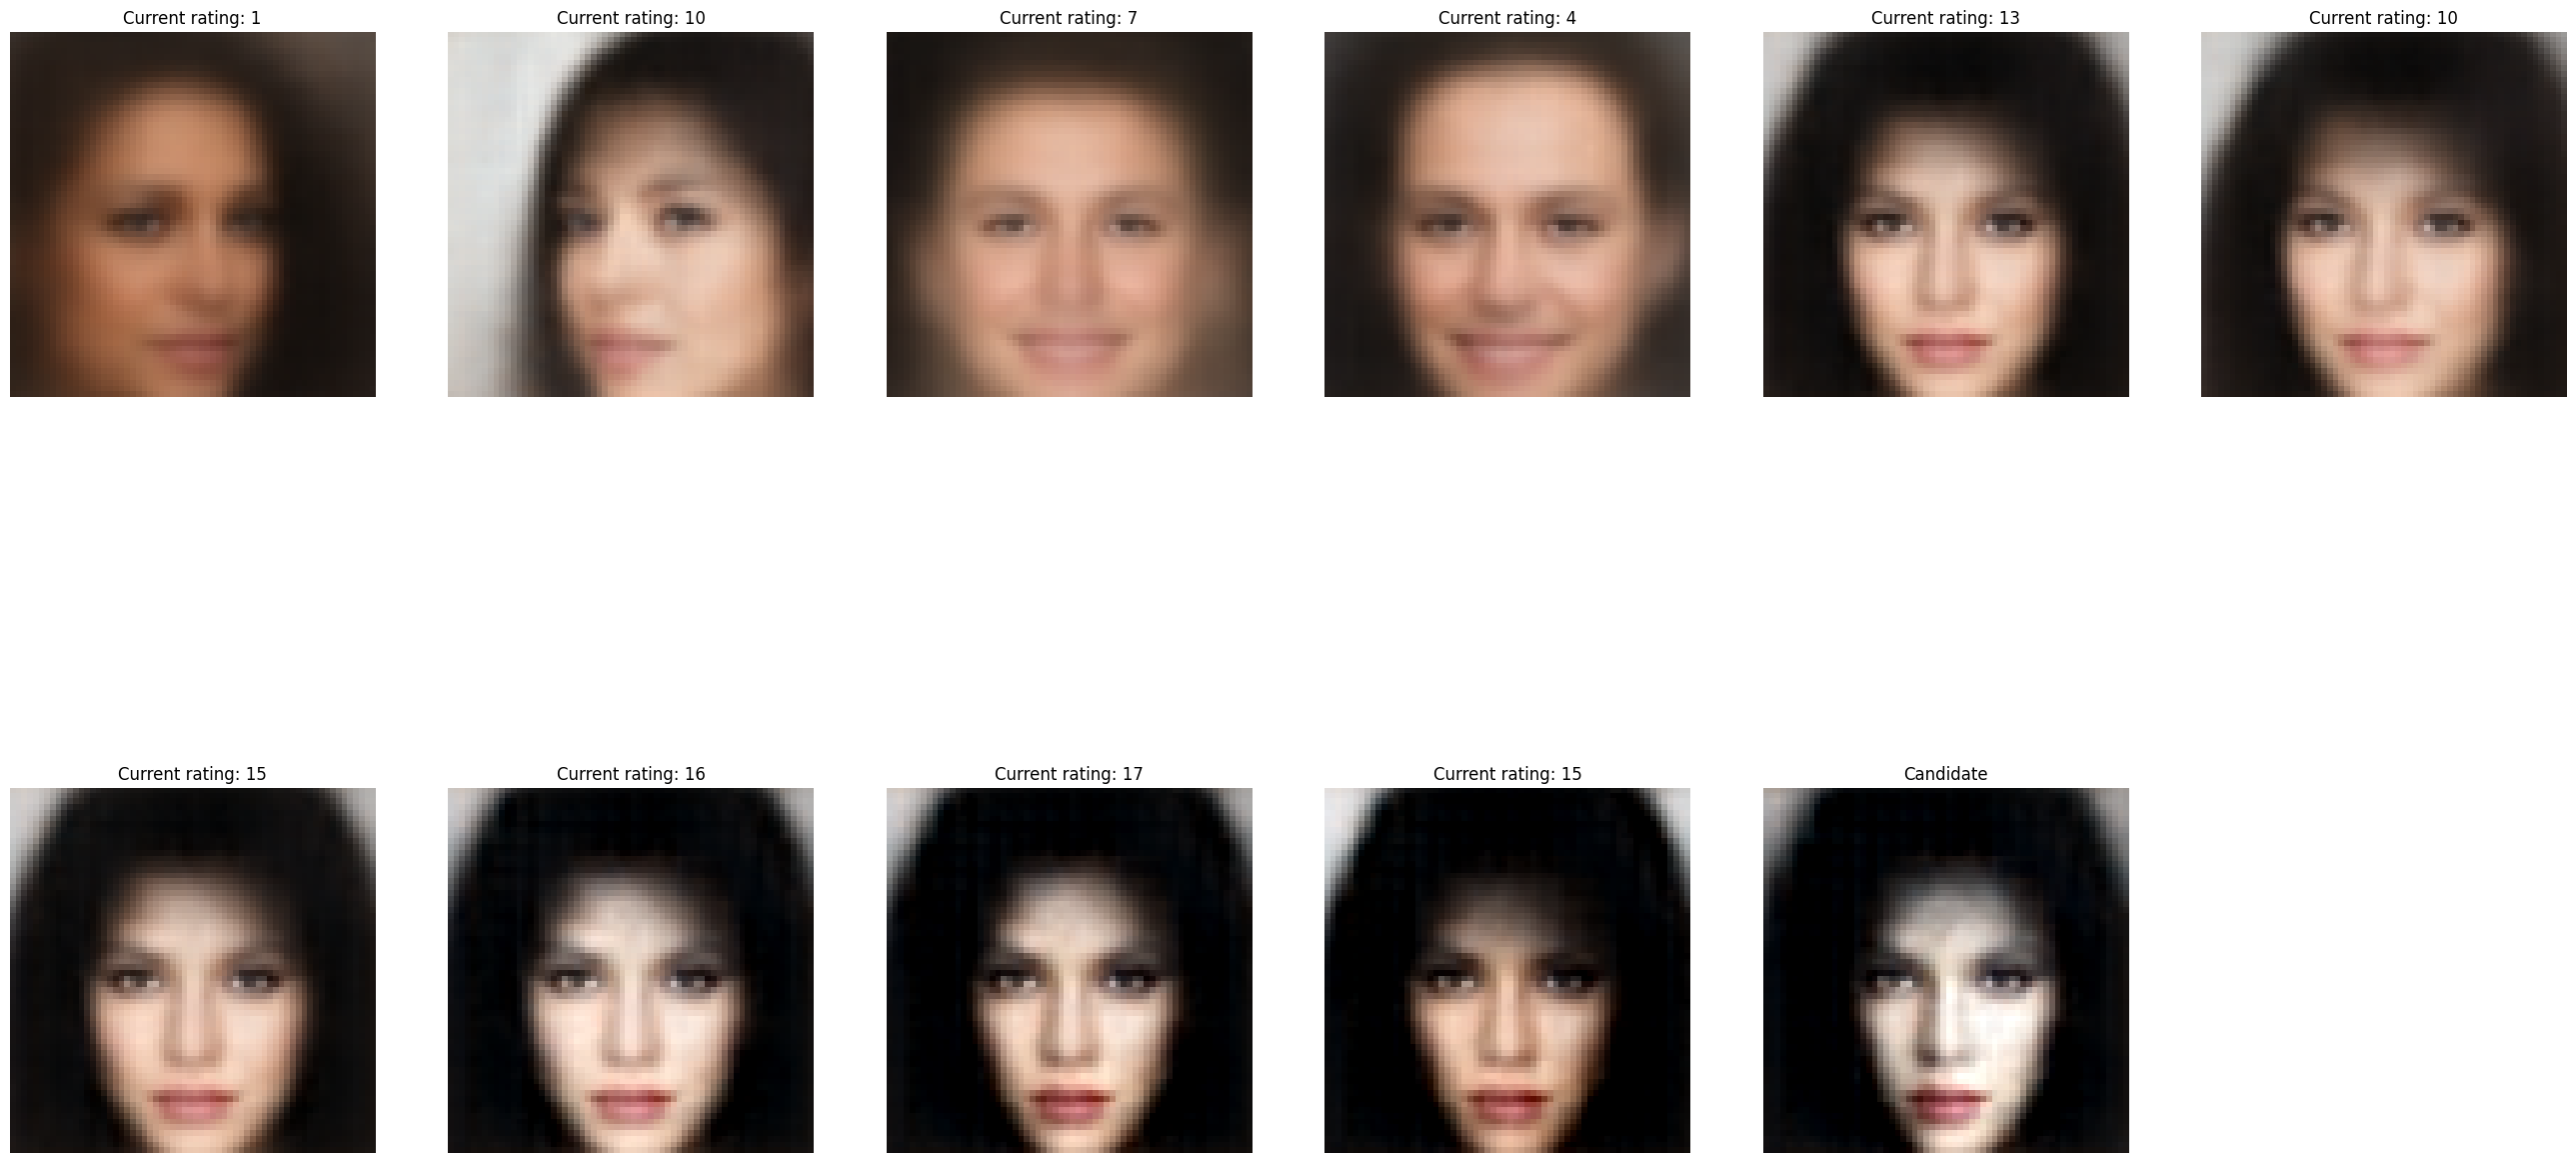

Rate the image with rating. Please see currently assigned ratings above the images!
15


In [22]:
composit = FacialComposit(decoder, 8)
composit.optimize(n_iter=6)

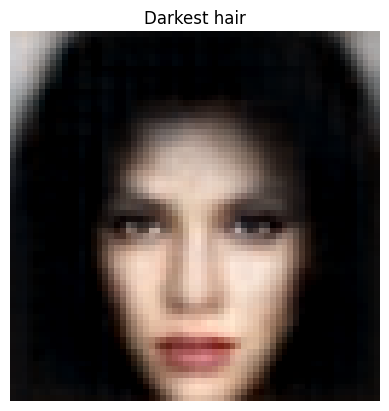

In [23]:
composit.draw_best('Darkest hair')

#### Task 3.2. Finding person with the widest smile (3 points)

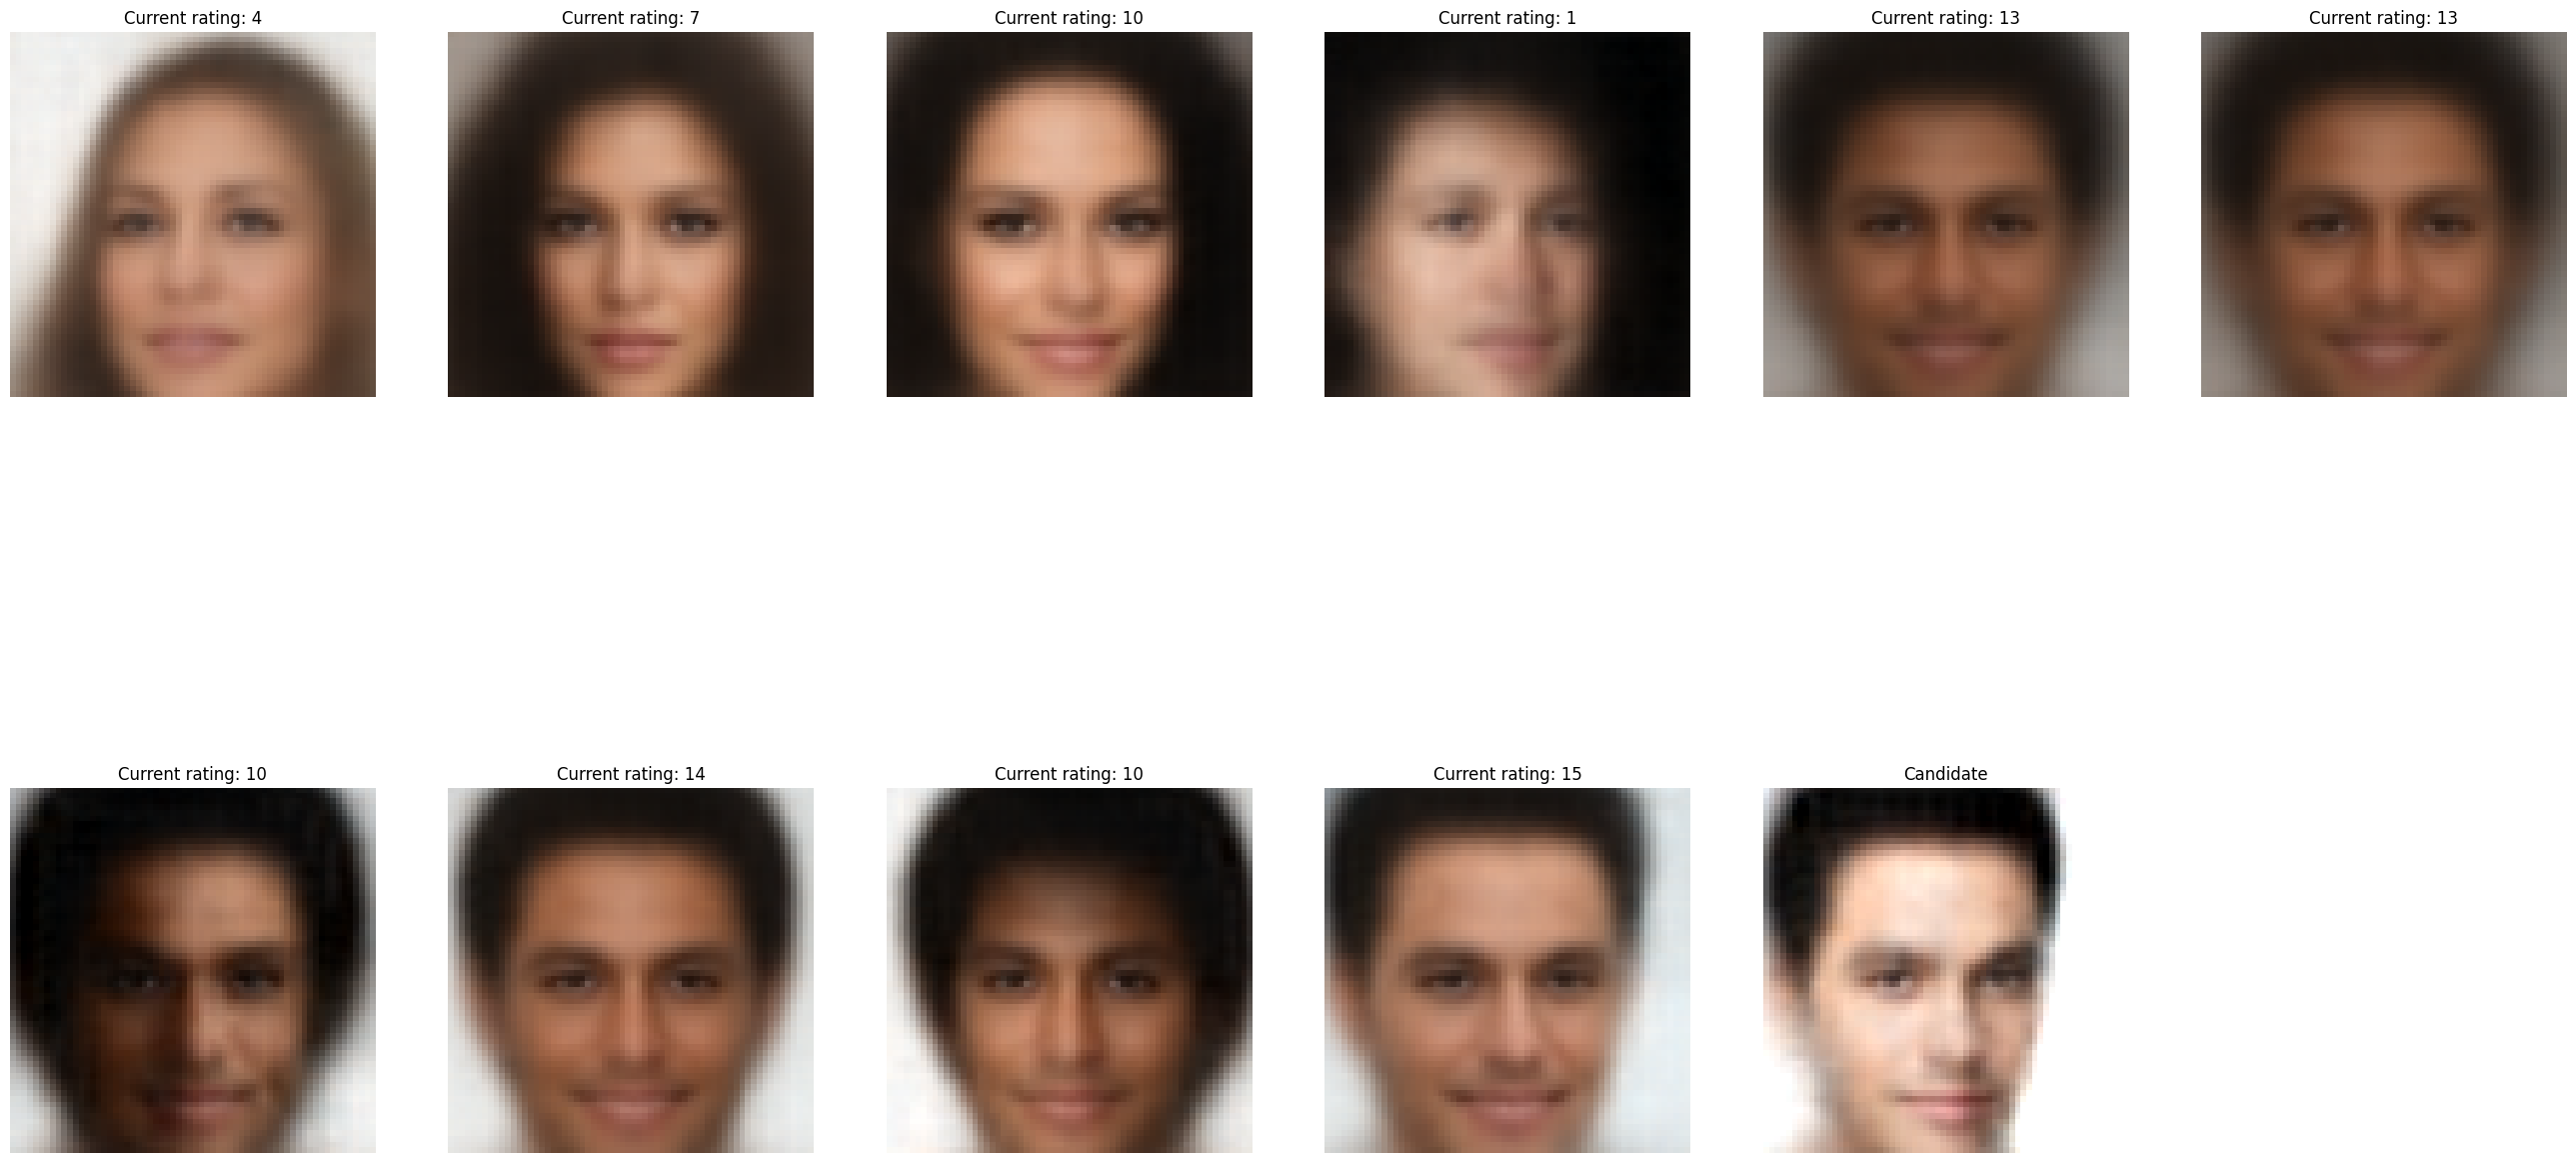

Rate the image with rating. Please see currently assigned ratings above the images!
10


In [24]:
composit = FacialComposit(decoder, 8)
composit.optimize(n_iter=6)

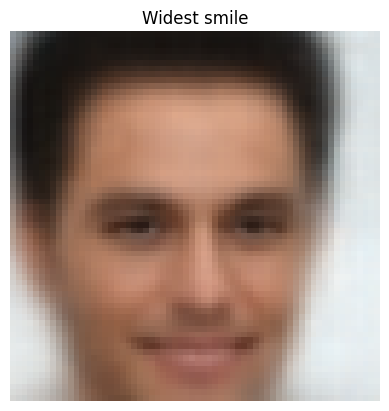

In [25]:
composit.draw_best('Widest smile')